舆情分析实验（1）文本主题分类
==================================

实验目的
---------------------
   - 熟悉简单的文本处理流程和神经网络文本分类模型
   
     文本分类是将文本按照一定的标准进行分类，比如新闻可以按照内容主题分为体育、科学等等。分类的“规则”可以由人确定，也可以用算法从有标签数据中自动归纳。人工制定分类规则可能并不容易，比如要区分体育和科学新闻，以有没有出现体育项目和运动员姓名来分类是可行的，但制定查找表并不容易，并且不能排除主要讲科学的新闻中出现这些词。自动算法帮助我们从文本中提取特征进行分类，并具有良好的性能和适应性。
       - 利用简单的神经网络对文本主题进行分类
       
       输入：一段文本
       
       输出：预先定义好的主题类别，如：体育、科学等
       
       
   - 初步了解深度学习框架pytorch的使用
   
     pytorch是一个开源深度学习框架，是一个基于Python的可续计算包，提供两个高级功能：1、具有强大的GPU加速的张量计算（如NumPy）。2、包含自动求导系统的深度神经网络。

实验环境
---------------------
   - Anaconda（当前python3.8）
   
   https://www.anaconda.com/products/individual-d
   
   - pytorch（当前torch 1.9.1） pip install torch
      - pytorch是一个开源的深度学习框架，能够利用GPU加速计算
   
   - torchtext（当前torchtext 0.10.1）
   pip install torchtext
   
   - cuda（英伟达显卡） GPU加速必备
   参考教程
   
   https://blog.csdn.net/weixin_43848614/article/details/117221384

实验数据
---------------------

新闻数据集AG_NEWS

AG_NEWS数据集由4大类主题

("World","Sports","Business","Sci/Tech")

的新闻的标题和描述字段组合而成，每类包含 30,000 个训练和 1,900 个测试样本。

如不能自动下载请访问以下链接


train:`https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv`

test:`https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv`

实验步骤
---------------------

访问原始数据集
---------------------

torchtext 库提供了一些原始数据集迭代器，它们给出原始文本字符串。 例如，“AG_NEWS”数据集迭代器将原始数据以标签和文本的元组给出。

("World","Sports","Business","Sci/Tech")对应于标签("1","2","3","4")

In [1]:
import torch
from torchtext.datasets import AG_NEWS
train_iter = AG_NEWS(split='train')

::

    next(train_iter)
    >>> (3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - 
    Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green 
    again.")

    next(train_iter)
    >>> (3, 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private 
    investment firm Carlyle Group,\\which has a reputation for making well-timed 
    and occasionally\\controversial plays in the defense industry, has quietly 
    placed\\its bets on another part of the market.')

    next(train_iter)
    >>> (3, "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring 
    crude prices plus worries\\about the economy and the outlook for earnings are 
    expected to\\hang over the stock market next week during the depth of 
    the\\summer doldrums.")




In [2]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [3]:
next(train_iter)

(3,
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')

In [4]:
next(train_iter)

(3,
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")

准备数据处理管道
---------------------------------

第一步是使用原始训练数据集构建词汇表。`get_tokenizer`函数对文本进行分词。这里我们使用内置函数`build_vocab_from_iterator` 接受迭代器,它能自动构建词汇表，并把传入的文本字符串转成代表token的整数序列。还可以将任何特殊符号自主添加到词汇表。

In [5]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
# 分词
train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
# 用<unk>填充那些不在词表中的词。
# 词表很难包括所有可能出现的词，这称为out of vocabulary问题（OOV）

## vocab将token列表转换为整数。

::

     vocab(['here', 'is', 'an', 'example'])
     >>> [475, 21, 30, 5286]

In [6]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

In [7]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

文本管道根据词汇表中定义的token查找表将文本字符串转换为整数列表。标签管道将标签转换为整数。 例如，

::

     text_pipeline('here is the an example')
     >>> [475, 21, 2, 30, 5286]
     label_pipeline('3')
     >>> 2

注意'3'是字符串格式，转换成整数2

数据批处理函数和加载器
--------------------------------

`torch.utils.data.DataLoader `
它与实现"getitem()"和"len()"的数据集类一起使用，并表示从索引/键到数据样本的映射。

在发送到模型之前，``collat​​e_fn`` 函数处理从``DataLoader`` 读取的一批样本。 ``collat​​e_fn`` 的输入是在``DataLoader`` 中具有大小batch的一批数据，``collat​​e_fn`` 根据之前声明的数据处理函数对其进行处理。

在这个例子中，原始数据批量输入中的文本条目被打包到一个列表中，并连接为 nn.EmbeddingBag 输入的单个张量。offsets是偏移量的张量，用于表示文本张量中单个序列的开始索引。label是保存单个文本条目标签的张量。

In [8]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 检测是否有安装了cuda的显卡可用

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
        # 所谓偏移量可以理解为该文本的长度
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)    

train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)
# shuffle=True将打乱数据集，batch_size使得加载器每次读取该数量的条目

定义模型
----------------

该模型由 `nn.EmbeddingBag层和用于分类目的的线性层组成。

尽管此处的每条文本具有不同的长度，但 nn.EmbeddingBag 模块在此处不需要填充，因为文本长度保存在偏移量中。


![jupyter](https://pytorch.org/tutorials/_images/text_sentiment_ngrams_model.png)

In [10]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        # self.embedding.weight.requires_grad = False
        self.fc = nn.Linear(embed_dim, num_class) #这个就是线性层
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [129]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.embedding.weight.requires_grad = True
        self.fc = nn.Linear(embed_dim, num_class) #这个就是线性层
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [18]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        # self.embedding.weight.requires_grad = False
        self.fc1 = nn.Linear(embed_dim, num_class * 4) #这个就是线性层
        self.fc2 = nn.Linear(num_class * 4, num_class) #第二层线性层
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        linear = self.fc1(embedded)
        return self.fc2(linear) #前向传播至第二层线性层

In [19]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        # self.embedding.weight.requires_grad = False
        self.fc1 = nn.Linear(embed_dim, num_class * 4) #这个就是线性层
        self.tanh = nn.Tanh() #tanh激活函数
        self.fc2 = nn.Linear(num_class * 4, num_class) #第二层线性层
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        linear1 = self.fc1(embedded)
        tanh = self.tanh(linear1) #前向传播至tanh层
        return self.fc2(tanh)

In [21]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        # self.embedding.weight.requires_grad = False
        self.fc1 = nn.Linear(embed_dim, num_class * 4) #这个就是线性层
        self.relu = nn.ReLU() #relu激活函数
        self.fc2 = nn.Linear(num_class * 4, num_class) #第二层线性层
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        linear1 = self.fc1(embedded)
        relu = self.relu(linear1) #前向传播至relu层
        return self.fc2(relu)

In [112]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        # self.embedding.weight.requires_grad = False
        self.fc1 = nn.Linear(embed_dim, num_class * 4) #这个就是线性层
        self.sigmoid = nn.Sigmoid() #sigmoid激活函数
        self.fc2 = nn.Linear(num_class * 4, num_class) #第二层线性层
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        linear1 = self.fc1(embedded)
        sigmoid = self.sigmoid(linear1) #前向传播至sigmoid层
        return self.fc2(sigmoid)

固定随机数种子
---------------

In [130]:
def seed_torch(seed=6):

    #random.seed(seed)
    # os.environ['PYTHONHASHSEED'] = str(seed)
    #np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch()

启动一个实例
--------------------

``AG_NEWS`` 数据集有四个标签，因此类的数量是四个。

::

    1： 世界
    2 : 运动
    3 : 商务
    4 : 科学/技术

我们构建了一个嵌入维度为 64 的模型。类的数量等于标签的数量。

In [131]:
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

定义用于训练模型和评估结果的函数。
---------------------------------------------------------

In [132]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

拆分数据集并运行模型
---------------------

由于原始``AG_NEWS`` 没有用来验证的数据集，我们拆分
将训练数据集转换为训练集/验证集，分割比为 0.95（训练集）和
0.05（验证集）。我们使用
`torch.utils.data.dataset.random_split`

`CrossEntropyLoss`
交叉熵损失函数，分类问题常用。

`SGD`
随机梯度下降法作为优化器。最初的
学习率设置为 5.0。

`StepLR`
用来调整学习率。

CPU参考运行时间：7分钟

GPU参考运行时间：5分钟

In [133]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters超参数
EPOCHS = 10 # epoch
LR = 5  # learning rate学习率
BATCH_SIZE = 64 # batch size for training

#定义损失函数
criterion = torch.nn.CrossEntropyLoss()
#定义优化器
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_iter, test_iter = AG_NEWS()
# train_iter, test_iter是迭代器的形式，to_map_style_dataset将其
# 转成DataLoader能读取的格式，参考torch.utils.data.Dataset类
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

accu_list = []

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    
    accu_list.append(accu_val)
    
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.687
| epoch   1 |  1000/ 1782 batches | accuracy    0.855
| epoch   1 |  1500/ 1782 batches | accuracy    0.877
-----------------------------------------------------------
| end of epoch   1 | time: 15.06s | valid accuracy    0.884 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.900
| epoch   2 |  1000/ 1782 batches | accuracy    0.899
| epoch   2 |  1500/ 1782 batches | accuracy    0.903
-----------------------------------------------------------
| end of epoch   2 | time: 15.09s | valid accuracy    0.891 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.915
| epoch   3 |  1000/ 1782 batches | accuracy    0.913
| epoch   3 |  1500/ 1782 batches | accuracy    0.915
-----------------------------------------------------------
| end of epoch   3 | time: 13.59s | valid accuracy    0.897 
-------------------------------

In [33]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

def train_model(EPOCHS, LR, BATCH_SIZE):
    
    #定义损失函数
    criterion = torch.nn.CrossEntropyLoss()
    #定义优化器
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    total_accu = None

    train_iter, test_iter = AG_NEWS()
    # train_iter, test_iter是迭代器的形式，to_map_style_dataset将其
    # 转成DataLoader能读取的格式，参考torch.utils.data.Dataset类
    train_dataset = to_map_style_dataset(train_iter)
    test_dataset = to_map_style_dataset(test_iter)

    num_train = int(len(train_dataset) * 0.95)
    split_train_, split_valid_ = \
        random_split(train_dataset, [num_train, len(train_dataset) - num_train])

    train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                                  shuffle=True, collate_fn=collate_batch)
    valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                                  shuffle=True, collate_fn=collate_batch)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                 shuffle=True, collate_fn=collate_batch)

    accu_list = []

    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        train(train_dataloader)
        accu_val = evaluate(valid_dataloader)
        if total_accu is not None and total_accu > accu_val:
            scheduler.step()
        else:
            total_accu = accu_val
        print('-' * 59)
        print('| end of epoch {:3d} | time: {:5.2f}s | '
              'valid accuracy {:8.3f} '.format(epoch,
                                               time.time() - epoch_start_time,
                                               accu_val))

        accu_list.append(accu_val)

        print('-' * 59)
        
    return accu_list[-1]

ac_list = []

for i in range(5, 21, 5):
    ac = train_model(i, 5, 64)
    print(ac, end=', ')
    ac_list.append(ac)

KeyboardInterrupt: 

In [134]:
for i in accu_list:
    print(i, end=', ')

0.8843333333333333, 0.8913333333333333, 0.8971666666666667, 0.9085, 0.9058333333333334, 0.9125, 0.911, 0.9126666666666666, 0.9113333333333333, 0.9113333333333333, 

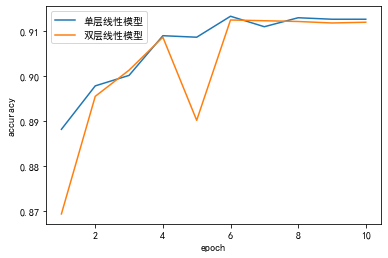

In [52]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(10)]

accu1_list = [0.8881666666666667, 0.8978333333333334, 0.9001666666666667, 0.909, 0.9086666666666666, 0.9133333333333333, 0.911, 0.913, 0.9126666666666666, 0.9126666666666666]
#accu2_list = [0.8711666666666666, 0.8858333333333334, 0.8683333333333333, 0.9058333333333334, 0.9086666666666666, 0.9051666666666667, 0.9068333333333334, 0.9071666666666667, 0.9073333333333333, 0.9073333333333333]
accu2_list = [0.8693333333333333, 0.8955, 0.9013333333333333, 0.9086666666666666, 0.8901666666666667, 0.9125, 0.9123333333333333, 0.9121666666666667, 0.9118333333333334, 0.912]

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(x, accu1_list, label='单层线性模型')
plt.plot(x, accu2_list, label='双层线性模型')
plt.legend()
plt.show()

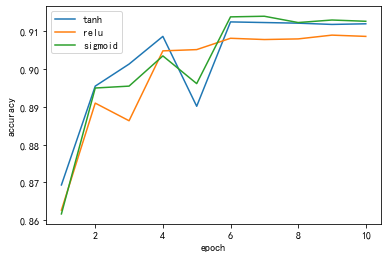

In [24]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(10)]

accu1_list = [0.8693333333333333, 0.8955, 0.9013333333333333, 0.9086666666666666, 0.8901666666666667, 0.9125, 0.9123333333333333, 0.9121666666666667, 0.9118333333333334, 0.912]
accu2_list = [0.8626666666666667, 0.891, 0.8863333333333333, 0.9048333333333334, 0.9051666666666667, 0.9081666666666667, 0.9078333333333334, 0.908, 0.909, 0.9086666666666666]
accu3_list = [0.8616666666666667, 0.895, 0.8955, 0.9035, 0.8961666666666667, 0.9138333333333334, 0.914, 0.9123333333333333, 0.913, 0.9126666666666666]

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(x, accu1_list, label='tanh')
plt.plot(x, accu2_list, label='relu')
plt.plot(x, accu3_list, label='sigmoid')
plt.legend()
plt.show()

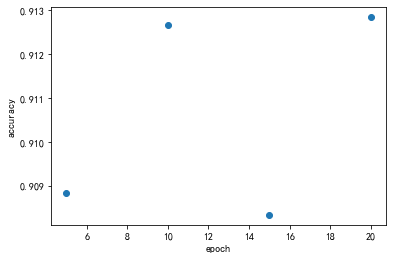

In [74]:
import matplotlib.pyplot as plt

x = [5, 10, 15, 20]

accu_list = [0.9088333333333334, 0.9126666666666666, 0.9083333333333333, 0.9128333333333334]

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.scatter(x, accu_list)
plt.show()

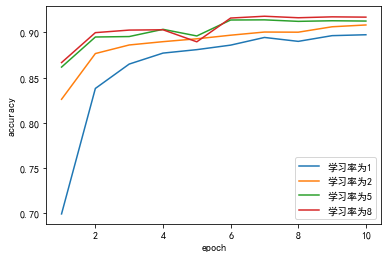

In [99]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(10)]

accu1_list = [0.699, 0.838, 0.865, 0.8771666666666667, 0.881, 0.886, 0.8945, 0.8901666666666667, 0.8965, 0.8975]
accu2_list = [0.826, 0.8766666666666667, 0.8861666666666667, 0.8898333333333334, 0.893, 0.897, 0.9005, 0.9003333333333333, 0.9063333333333333, 0.9083333333333333]
accu3_list = [0.8616666666666667, 0.895, 0.8955, 0.9035, 0.8961666666666667, 0.9138333333333334, 0.914, 0.9123333333333333, 0.913, 0.9126666666666666]
accu4_list = [0.8666666666666667, 0.8998333333333334, 0.9026666666666666, 0.903, 0.8896666666666667, 0.916, 0.918, 0.9163333333333333, 0.9173333333333333, 0.917]

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(x, accu1_list, label='学习率为1')
plt.plot(x, accu2_list, label='学习率为2')
plt.plot(x, accu3_list, label='学习率为5')
plt.plot(x, accu4_list, label='学习率为8')
plt.legend()
plt.show()

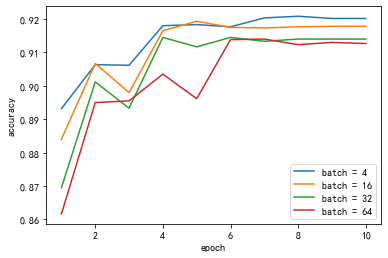

In [118]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(10)]

accu1_list = [0.8931666666666667, 0.9063333333333333, 0.9061666666666667, 0.918, 0.9183333333333333, 0.9176666666666666, 0.9203333333333333, 0.9208333333333333, 0.9201666666666667, 0.9201666666666667]
accu2_list = [0.884, 0.9066666666666666, 0.898, 0.9165, 0.9193333333333333, 0.9175, 0.9173333333333333, 0.9176666666666666, 0.9178333333333333, 0.9178333333333333]
accu3_list = [0.8695, 0.9011666666666667, 0.8933333333333333, 0.9145, 0.9116666666666666, 0.9145, 0.9133333333333333, 0.914, 0.914, 0.914]
accu4_list = [0.8616666666666667, 0.895, 0.8955, 0.9035, 0.8961666666666667, 0.9138333333333334, 0.914, 0.9123333333333333, 0.913, 0.9126666666666666]

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(x, accu1_list, label='batch = 4')
plt.plot(x, accu2_list, label='batch = 16')
plt.plot(x, accu3_list, label='batch = 32')
plt.plot(x, accu4_list, label='batch = 64')
plt.legend()
plt.show()

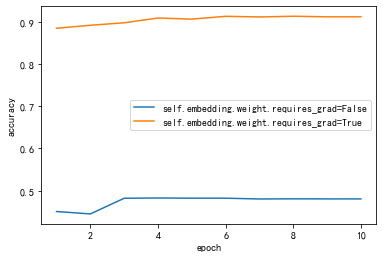

In [135]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(10)]

accu1_list = [0.451, 0.44533333333333336, 0.48233333333333334, 0.483, 0.4825, 0.4825, 0.4806666666666667, 0.481, 0.48083333333333333, 0.48083333333333333]
accu2_list = [0.8843333333333333, 0.8913333333333333, 0.8971666666666667, 0.9085, 0.9058333333333334, 0.9125, 0.911, 0.9126666666666666, 0.9113333333333333, 0.9113333333333333]

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(x, accu1_list, label='self.embedding.weight.requires_grad=False')
plt.plot(x, accu2_list, label='self.embedding.weight.requires_grad=True')
plt.legend()
plt.show()

使用测试数据集评估模型
---------------------

检查测试数据集的结果…

In [23]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.899


测试一条新闻
---------------------

使用该模型并测试一条高尔夫新闻（体育）。

In [16]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tec"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text.to(device), torch.tensor([0]).to(device))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

print("This is a %s news" %ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news


使用LSTM模型
---------------------

长短期记忆网络——通常被称为 LSTM，是一种特殊的 RNN，能够学习长期依赖性。由 Hochreiter 和 Schmidhuber（1997）提出。

![jupyter](https://n.sinaimg.cn/spider202044/731/w1040h491/20200404/0bc7-irtymmw0458671.png)

CPU参考运行时间：30分钟

GPU参考运行时间：8分钟

In [18]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, bidirectional=False)
        # num_layers定义了LSTM网络的层数，bidirectional表示是单向LSTM还是双向LSTM（BiLSTM）
        self.fc = nn.Linear(hidden_size, num_class)
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets).unsqueeze(1)

        output, (hn, cn) = self.lstm(embedded)
        return self.fc(output)

In [25]:
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
hidden_size = 100
num_layers = 1
LSTM_model = LSTM(vocab_size, emsize, num_class, hidden_size, num_layers).to(device)

In [26]:
import time

def train(dataloader):
    LSTM_model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = LSTM_model(text, offsets).squeeze()
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(LSTM_model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    LSTM_model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = LSTM_model(text, offsets).squeeze()
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [27]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters超参数
EPOCHS = 10 # epoch
LR = 5  # learning rate学习率
BATCH_SIZE = 64 # batch size for training
  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(LSTM_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.489
| epoch   1 |  1000/ 1782 batches | accuracy    0.779
| epoch   1 |  1500/ 1782 batches | accuracy    0.836
-----------------------------------------------------------
| end of epoch   1 | time: 31.15s | valid accuracy    0.828 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.870
| epoch   2 |  1000/ 1782 batches | accuracy    0.880
| epoch   2 |  1500/ 1782 batches | accuracy    0.885
-----------------------------------------------------------
| end of epoch   2 | time: 31.35s | valid accuracy    0.883 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.902
| epoch   3 |  1000/ 1782 batches | accuracy    0.899
| epoch   3 |  1500/ 1782 batches | accuracy    0.905
-----------------------------------------------------------
| end of epoch   3 | time: 31.27s | valid accuracy    0.888 
-------------------------------

In [ ]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

实验要求
-------------------

   - 配置实验环境，阅读教程样例并运行，理解实验流程
    
   - 将教程中的单层线性模型改为双层模型，并比较至少三组超参数和两种激活函数，写入实验报告
       - 需要了解的内容：激活函数，如nn.Tanh()等
   
   - 解除TextClassificationModel中一行代码的注释，再次运行模型，比较前后结果，并解释为什么，写入实验报告

参考文献

https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

提交时间
----------------

10月23日前

提交格式：word或pdf
`学号-姓名-实验1`

提交地址:
`https://workspace.jianguoyun.com/inbox/collect/8d90cb29f6e04a1c87edb7647768c046/submit`